# Simple demo of [BiGR](https://arxiv.org/abs/2410.14672)

In [41]:
# clone BiGR and install environments

!git clone https://github.com/haoosz/BiGR.git
import BiGR, os
os.chdir('BiGR')
os.environ['PYTHONPATH'] = '/env/python:/content/BiGR'
# DiT imports:
import torch
import argparse
import numpy as np
from torchvision.utils import save_image
from PIL import Image
from IPython.display import display
from torchvision.datasets.utils import download_url
from hparams import args2H
from llama.load_bigr import load_bigr
from bae.binaryae import BinaryAutoEncoder, load_pretrain
torch.set_grad_enabled(False)
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cpu":
    print("GPU not found. Using CPU instead.")

Cloning into 'BiGR'...
remote: Enumerating objects: 190, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 190 (delta 26), reused 32 (delta 12), pack-reused 135 (from 1)
Receiving objects: 100% (190/190), 49.41 MiB | 15.61 MiB/s, done.
Resolving deltas: 100% (45/45), done.


In [60]:
# download
def download_model(url, model_name):
    os.makedirs('pretrained_models', exist_ok=True)
    download_url(url, 'pretrained_models')
    local_path = 'pretrained_models/' + model_name
    return local_path

def find_model(args, model):
    model, size, code_dim = model.strip().split('-')
    code_dim = code_dim.split('d')[-1]
    args.model = model + '-' + size
    args.codebook_size = int(code_dim)
    url_ckpt = f"https://huggingface.co/haoosz/BiGR/resolve/main/gpt/bigr_{size}_d{code_dim}.pt"
    args.ckpt = download_model(url_ckpt, f"bigr_{size}_d{code_dim}.pt")

    if code_dim == '24':
      url_ckpt_bae = "https://huggingface.co/haoosz/BiGR/resolve/main/bae/bae_d24/binaryae_ema_1000000.th"
      args.ckpt_bae = download_model(url_ckpt_bae, "binaryae_ema_1000000.th")
    elif code_dim == '32':
      url_ckpt_bae = "https://huggingface.co/haoosz/BiGR/resolve/main/bae/bae_d32/binaryae_ema_950000.th"
      args.ckpt_bae = download_model(url_ckpt_bae, "binaryae_ema_950000.th")

def args_parser():
    # some hyperparameters
    parser = argparse.ArgumentParser()
    args = parser.parse_args(args=[])

    args.image_size = args.img_size = 256
    args.num_classes = 1000
    args.dataset = 'custom'
    args.norm_first = True
    args.cls_token_num = 1
    args.dropout_p = 0.1
    args.token_dropout_p = 0.0
    args.drop_path_rate = 0.0
    args.use_adaLN = True
    args.p_flip = True
    args.focal = 0.0
    args.alpha = -1
    args.aux = 0.0
    args.n_repeat = 1
    args.n_sample_steps = 256
    args.seq_len = 256
    args.temperature = 1.0
    args.cfg_schedule = 'constant'
    args.gumbel_schedule = 'down'
    args.infer_steps = 100
    return args


In [61]:
# model config
model = "BiGR-L-d24" #@param ["BiGR-L-d24", "BiGR-XL-d24", "BiGR-XXL-d24", "BiGR-XXL-d32"]

args = args_parser()
find_model(args, model)
args_ae = args2H(args)

# load B-AE
bae = BinaryAutoEncoder(args_ae).to(device).eval()
bae = load_pretrain(bae, args.ckpt_bae)
print(f"The code length of B-AE is set to {args_ae.codebook_size}")

# load BiGR
model = load_bigr(args, args_ae, device).eval()
print(f"GPT Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"MLP Parameters in GPT: {sum(p.numel() for p in model.denoise_mlp.parameters()):,}")


Using downloaded and verified file: pretrained_models/bigr_L_d24.pt
Using downloaded and verified file: pretrained_models/binaryae_ema_1000000.th
The code length of B-AE is set to 24
We are using adaLN!
GPT Parameters: 336,346,136
MLP Parameters in GPT: 20,255,768


You can find the full list of ImageNet classes [here](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).

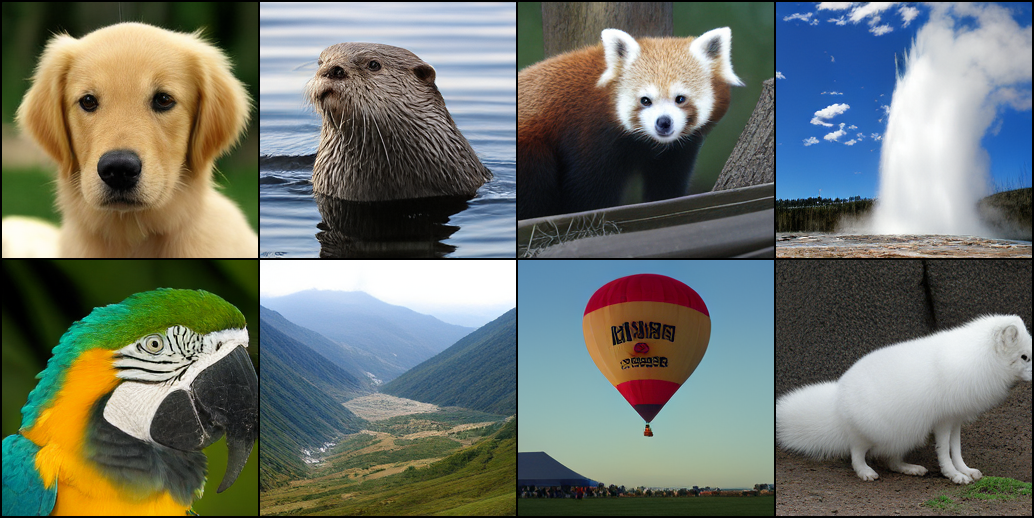

In [63]:
seed = 0 #@param {type:"raw"}
torch.manual_seed(seed)
np.random.seed(seed)

cfg_scale = 2.5 #@param {type:"slider", min:2, max:5, step:0.1}
num_sample_iter = 20 #@param {type:"slider", min:10, max:30, step:5}
gumbel_temp = 0.01 #@param {type:"slider", min:0.00, max:0.03, step:0.005}

# Labels to condition the model with (feel free to change):
class_labels = [207, 360, 387, 974, 88, 979, 417, 279] #@param {type:"raw"}
latent_size = args.image_size // 16

n = len(class_labels)
y = torch.tensor(class_labels, device=device)

bs = y.shape[0]

# sample!
with torch.no_grad():
    samples = model.generate_with_cfg(cond=y, max_new_tokens=latent_size ** 2, cond_padding=args.cls_token_num, num_iter=num_sample_iter,
                out_dim=bae.codebook_size, cfg_scale=cfg_scale, cfg_schedule=args.cfg_schedule,
                gumbel_temp=gumbel_temp, gumbel_schedule=args.gumbel_schedule, sample_logits=True, proj_emb=None)

samples = samples.float().transpose(1,2).reshape(bs, -1, latent_size, latent_size)
samples = bae.decode(samples)
save_image(samples, 'sample.png', nrow=4, normalize=True, value_range=(0, 1))
samples = Image.open("sample.png")
display(samples)
